In [230]:
# !!! need to install xlrd==1.2.0, numpy==1.26.4, pandas==1.3.5, or pandas won't read the .xlsx files generated by the software
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat

# Get measurements from individual excel files
measurement_numbers = np.arange(6,61)
measurements = []
for i in range(measurement_numbers[-1]+1):
    if i < measurement_numbers[0]:
        measurements.append(np.nan)
        continue
    measurements.append(pd.read_excel(f'measurements/{i}.xlsx', engine='xlrd').values[:,0])
    # clean #NV values
    for j in range(len(measurements[-1])):
        if measurements[-1][j] == '#NV':
            measurements[-1][j] = np.nan
measurements = measurements[6:]


# Get v_stop
v_stop = np.loadtxt("measurements/v_stop.txt")

/var/folders/7j/bs4xx7fn0qs5qbg6nsyxmczr0000gn/T/ipykernel_67914/2493224224.py:14: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. Install openpyxl instead.
  measurements.append(pd.read_excel(f'measurements/{i}.xlsx', engine='xlrd').values[:,0])


Text(0, 0.5, 'Velocity (mm/s)')

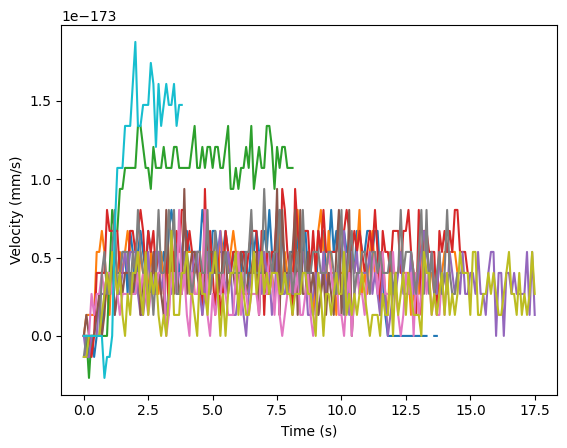

In [ ]:
# constants from manual 
rho_oil = 875.3 # kg/m^3
rho_air = 1.204 # kg/m^3
g = 9.80 # m/s^2
nu_air = 1.827e-5 # Ps s at 1 atm
d = 6.0/1000 # m (parallel plate distance)
frame_rate = 10 # Hz
conversion_ratio = ufloat(540,1) # px / mm

# convert pixels to mm 
measurements = [m / conversion_ratio for m in measurements] # mm

# calculate velociites using framerate 
# v is dy/dt = (10 Frame / s) * (dy / 1 Frame)
velocites = [np.diff(m)*frame_rate for m in measurements] # mm/s
times = [np.arange(0, len(v)/frame_rate, 1/frame_rate) for v in velocites]

for m in range(len(measurements))[:10]:
    plt.plot(times[m], [v.n for v in velocites[m]])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (mm/s)')
